In [1]:
#!pip uninstall tensorflow

In [2]:
#!pip install tensorflow-gpu==2.0.0

In [1]:
from tensorflow.compat.v1 import enable_eager_execution
import tensorflow as tf
import numpy as np
import os
import tensorflow_probability as tfp
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
import random
from sklearn.metrics import confusion_matrix
print(tf.__version__)

2.0.0


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

## 參數設定

In [3]:
flatten_size = 32 * 32 * 3
img_size = 32
img_channel = 3
regular = 1e-5

z_dim = 128
h_dim = [32, 64, 128]
objective = 'deep-SVDD'     #'  'soft-boundary'


## 匯入資料（MNIST）

In [4]:
names = np.array(['airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'])

In [5]:
location  = 'E:/咪聽/SVDD/deep SVDD/checkpoints/'
location  = 'D:/7107018014/checkpoint/'

In [6]:
def load_data(label_num, batch_size = 200, outlier_nu = 0.1):
    # 0: normal, 1: outlier
    
    x_train = np.load('D:/7107018014/cifar10/{}/{}_data{}_batch{}.npy'.format(label_num,'train',label_num, 0))
    y_train = np.load('D:/7107018014/cifar10/{}/{}_label{}_batch{}.npy'.format(label_num,'train',label_num, 0))
    x_train = np.transpose(x_train, (0, 2, 3, 1))
    
    
    for i in np.arange(2):
        data = np.load('D:/7107018014/cifar10/{}/{}_data{}_batch{}.npy'.format(label_num,'test',label_num, i))
        label = np.load('D:/7107018014/cifar10/{}/{}_label{}_batch{}.npy'.format(label_num,'test',label_num, i))
        
        data = np.transpose(data, (0, 2, 3, 1))
        try:
            x_test = np.vstack((x_test, data))
            y_test = np.hstack((y_test, label))
        except:
            x_test = data
            y_test = label
    ## outlier data
    for index in np.delete(np.arange(10), label_num):
        
        out_data = np.load('D:/7107018014/cifar10/{}/{}_data{}_batch{}.npy'.format(index,'train',index, 0))
        out_label = np.load('D:/7107018014/cifar10/{}/{}_label{}_batch{}.npy'.format(index,'train',index, 0))

        out_data = np.transpose(out_data, (0, 2, 3, 1))
        try:
            out_datas_ = np.vstack((out_datas_, out_data))
            out_labels_ = np.hstack((out_labels_, out_label))
        except:
            out_datas_ = out_data
            out_labels_ = out_label
        
    ### 製造outlier
    random.seed (1120)
    normal_n = len(x_train)
    outlier_n = len(out_datas_) ####
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    x_train = np.vstack( (x_train[y_train == label_num], out_datas_[indices]))
    y_train = np.hstack( (y_train[y_train == label_num], out_labels_[indices]))
    
    
    # Flatten the dataset
    x_train = x_train.reshape((-1, flatten_size))
    x_test = x_test.reshape((-1, flatten_size))

    train_buf = x_train.shape[0]
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    train_dataset = train_dataset.shuffle(buffer_size=train_buf)
    train_dataset = train_dataset.batch(batch_size)
    
    return train_dataset, x_train, x_test, y_train, y_test

## 建構模型

## Prtrain

In [7]:
class Autoencoder():
    
    def __init__(self, label_num, img_size = img_size, z_dim = z_dim, h_dim = h_dim, img_channel = img_channel):
        
        self.label_num = label_num
        self.flatten_size = img_size * img_size * img_channel
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.ae_optimizer = tf.keras.optimizers.Adam(lr = 0.001, epsilon = 1e-6)
        

    def make_encoder(self):

        inputs = tf.keras.Input(shape=(self.flatten_size,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, 32, 32, 3))
        x = tf.keras.layers.Conv2D(self.h_dim[0], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(self.h_dim[1], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)
        
        x = tf.keras.layers.Conv2D(self.h_dim[2], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Flatten(name = 'Flatten')(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.Dense(self.z_dim, use_bias = False, name = 'dense')(x)
        
        
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model    
   
    def make_decoder(self):

        inputs = tf.keras.Input(shape=(self.z_dim,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, 4, 4, 8))
        x = tf.keras.layers.LeakyReLU()(x)
        #x = tf.keras.layers.UpSampling2D((2, 2))(x)    

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[2], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)   

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[1], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        
        x = tf.keras.layers.Conv2DTranspose(self.h_dim[0], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ELU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x) 
        
        x = tf.keras.layers.Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same',  use_bias = False)(x)
        #x = tf.reshape(x, shape = (-1, self.flatten_size))
        x = tf.keras.layers.Flatten(name = 'Flatten')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model   
    
    @tf.function
    def train_ae_model(self, batch_x):
        with tf.GradientTape() as ae_tape:
            ae_output = self.decoder(self.encoder(batch_x, training=True), training=True)
            loss = tf.reduce_mean((ae_output - batch_x) ** 2)

        grads = ae_tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        return loss
    
    def train_ae( self, n_ae_epochs, train_dataset, ae_lr_milestone=250 ):
        #loss_list = []
        for epoch in range(n_ae_epochs):
            epoch_ae_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % ae_lr_milestone == 0:
                self.ae_optimizer.lr = 0.1 * self.ae_optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):

                ae_loss = self.train_ae_model(batch_x)
                #epoch_ae_loss_avg(ae_loss)
            #loss_list.append(epoch_ae_loss_avg.result())
        
        self.encoder.save_weights('D:/7107018014/checkpoint/oneclassAE_label_{}' .format(self.label_num))
        #print('LOSS: {:.4f} '.format(epoch_ae_loss_avg.result()))
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        

In [8]:
ae = Autoencoder('airplane')

In [9]:
encoder = ae.encoder
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 3072)]            0         
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2400      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
elu (ELU)                    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51200 

In [10]:
decoder = ae.decoder
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 4, 4, 8)]         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         25600     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
elu_3 (ELU)                  (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 128)         0   

## result 

In [11]:
def threshold_img(data, dists):
    dict_score = {}
    for i in range(len(dists)):
        dict_score[float(dists[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [12]:
def threshold_uncertain_img(data, dists, r):
    dist2radius = (dists - r**2)
    normal = dist2radius[dist2radius<0]
    anomaly = dist2radius[dist2radius>0]
    normal_score = {}
    anomaly_score = {}
    for i in range(len(normal)):
        normal_score[float(normal[i])] = i
    for i in range(len(anomaly)):
        anomaly_score[float(anomaly[i])] = i
    normalsort_score = [(k, normal_score[k]) for k in sorted(normal_score.keys())]
    anomalysort_score = [(k, anomaly_score[k]) for k in sorted(anomaly_score.keys())]
    
    n_digits = min([len(normal),len(anomaly),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display normal
        
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[normalsort_score[-i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[anomalysort_score[i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [13]:
def distance_plot(label_num, dist, data, radius_end, objective, train = True, label = None,  nu = 0.1):
    treshold = radius_end ** 2
    if train:
        plt.title(str(objective) + 'label = {} train data'.format(label_num))
        if objective == 'soft-boundary':
            treshold = 0
            plt.hist(dis, rwidth=0.3, color='b' ,bins = 100)
            plt.axvline(treshold,  color='r')
        else:
            score = dist
            plt.hist(score, rwidth=0.3, color='b' ,bins = 100)
            plt.axvline(float(treshold),  color='g')
        plt.show()       
    
    else:
        plt.title(str(objective) + 'label = {} test data'.format(label_num))
        if objective == 'soft-boundary':
            plt.hist(dis[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(dis[label==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
            plt.axvline(treshold,  color='g')
            plt.legend()
            plt.show()
            plt.hist(dist[label==label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            plt.axvline(treshold, color='g')
            plt.legend()
            plt.show()
            plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.axvline(treshold, color='g')
        else:
            score = dist
            plt.hist(score[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.hist(score[label==label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            plt.axvline(float(treshold), color='g')
            plt.legend()
            plt.show()
            plt.hist(score[label==label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
            plt.axvline(float(treshold), color='g')
            plt.legend()
            plt.show()
            plt.hist(score[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
            plt.axvline(float(treshold), color='g')
        plt.legend()
        plt.show()
    


In [14]:
def false_img(data, labels_,  dists, r, label_num):
    dist2radius = (dists - r**2)
    dist_n = dist2radius[labels_ != label_num]
    dist_p = dist2radius[labels_ == label_num]
    data_n = data[labels_ != label_num]
    data_p = data[labels_ == label_num]
    fn = dist_n[dist_n<0]
    fp = dist_p[dist_p>0]
    fn_score = {}
    fp_score = {}
    for i in range(len(fn)):
        fn_score[float(fn[i])] = i
    for i in range(len(fp)):
        fp_score[float(fp[i])] = i
        
    fn_score_sort = [(k, fn_score[k]) for k in sorted(fn_score.keys())]
    fp_score_sort = [(k, fp_score[k]) for k in sorted(fp_score.keys())]
    
    n_digits = min([len(fn),len(fp),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display fn
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data_n[fn_score_sort[-i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display fp
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size, img_channel), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [15]:
class train_SVDD():
    
    def __init__(self, label_num , objective , encoder, train_dataset, nu = 0.1, z_dim = z_dim):
        names = np.array(['airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'])
        
        self.label_num = label_num
        self.label_name = names[label_num]
        self.objective = objective
        self.nu = nu
        self.z_dim = z_dim
        self.encoder = encoder
        self.label_num = label_num
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 1e-6)
        self.train_dataset = train_dataset
        self.center = self.init_center_c( eps = 0.1)
        
        
    def init_center_c(self, eps = 0.1):
        
        self.encoder.load_weights('D:/7107018014/checkpoint/oneclassAE_label_{}' .format(self.label_num))
        positive = tf.fill([self.z_dim], eps)
        negative = tf.fill([self.z_dim], -eps)
        c = tf.zeros(shape = [self.z_dim], dtype = tf.float32, name = 'c')
        
        for batch, (batch_x) in enumerate(self.train_dataset):
            output = self.encoder(batch_x, training=False)            
            if batch ==0:
                modeloutput = output
            else:
                modeloutput = tf.concat([modeloutput, output], 0)
        
        c = tf.reduce_mean(modeloutput, axis = 0, name = 'outputs')
        #c = tf.reduce_mean( self.encoder(data, training = False), axis = 0, name = 'outputs') 

        c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
        c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
        
        return c
        
    def get_radius(self,dist):
        """Optimally solve for radius R via the (1-nu)-quantile of distances."""
        return tfp.stats.percentile(tf.sqrt(dist), (1-self.nu)*100)


    def loss(self, objective, dist, R = None):

        if objective == 'soft-boundary':
            scores = dist - R**2
            avg_loss = R**2 + (1/nu) * tf.reduce_mean(tf.maximum(tf.zeros_like(scores), scores))

        if objective=='deep-SVDD':
            avg_loss = tf.reduce_mean(dist)
        return avg_loss

    @tf.function
    def train_model(self, batch_x, center, objective, R = None):
        with tf.GradientTape() as tape:
            output = self.encoder(batch_x, training=True)
            dist = tf.reduce_sum(tf.math.square(output - self.center) , axis=1)
            output_loss = self.loss(self.objective, dist, R)

        grads = tape.gradient(output_loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables))

        return output_loss, dist
    def train(self, x_train, n_epochs = 150, warm_up_n_epochs = 10, lr_milestone = 50):
        
        if self.objective == 'soft-boundary':
            self.R = tf.zeros(shape = [1], dtype = tf.float32, name = 'R')
        else:
            self.R = None
        loss_list = []
        
        for epoch in range(n_epochs):
            epoch_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % lr_milestone == 0:
                self.optimizer.lr = 0.1 * self.optimizer.lr
            
            for batch, (batch_x) in enumerate(self.train_dataset):
                loss_, dist = self.train_model(batch_x, self.center, self.objective, self.R )
                epoch_loss_avg(loss_)
                if (self.objective == 'soft-boundary') and (epoch >= warm_up_n_epochs):
                    self.R = self.get_radius(dist)
            loss_list.append(loss_)
        self.encoder.save_weights('D:/7107018014/checkpoint/{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_name, self.nu))
        np.save('D:/7107018014/checkpoint/radius_{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_name,self.nu), self.R.numpy() )
        plt.title('label = {}'.format(self.label_name))
        plt.plot(loss_list)
        plt.show()
        
    def distance(self, data, label, load_model = True):
        if load_model:
            self.encoder.load_weights('D:/7107018014/checkpoint/{}_label_{}_outlier_{}' .format
                                  (self.objective, self.label_name, self.nu))
        batch_size = 200
        train_dataset = tf.data.Dataset.from_tensor_slices((data, label))
        train_dataset = train_dataset.batch(batch_size)

        for batch, (batch_x,batch_y) in enumerate(train_dataset):
            output = self.encoder(batch_x, training=False)
            dist = tf.reduce_sum(tf.math.square(output - self.center) , axis=1) ## dist**2
            
            if batch ==0:
                modeloutput = dist
                labels_ = batch_y
                datas = batch_x
            else:
                modeloutput = tf.concat([modeloutput, dist], 0)
                labels_ = tf.concat([labels_, batch_y], 0)
                datas = tf.concat([datas, batch_x], 0)
                
        labels_ = labels_.numpy()
        datas = datas.numpy()
        
        return modeloutput, labels_, datas
    
    def decide_treshold(self, x_train, y_train):
        dis = 0
        if self.objective == 'soft-boundary':
            radius_end = np.load('D:/7107018014/checkpoint/radius_{}_label_{}_outlier_{}.npy' .format
                                  (self.objective, self.label_name, self.nu))
        else:
            dis, labels_, datas = self.distance(x_train, x_train)
            radius_end = self.get_radius(dis).numpy()
            
        return float(radius_end), dis
    
    def train_result(self, x_train, y_train, show_img = False, load_model = True):
        
        radius_end, dis = self.decide_treshold(x_train, x_train)
        
        if show_img:
            #if self.objective == 'soft-boundary':
            dis, labels_, datas = self.distance(x_train, y_train)
            dis = dis.numpy()
            distance_plot(self.label_num, dis, datas, radius_end, self.objective, self.nu, label = labels_)
            print(' train label = {} uncertain_img'.format(self.label_name))
            threshold_uncertain_img(datas, dis, radius_end)
            print('train label = {} distance oder'.format(self.label_name))
            threshold_img(datas, dis)
            print('train label = {} false_img'.format(self.label_name))
            false_img(datas, labels_,  dist, radius_end, self.label_num)
            
        return radius_end
    
    def result(self, dist, y_test, radius_end, show_img = False):
        
        y_true = y_test == self.label_num
        scores = dist - radius_end ** 2
        y_prob = 1/dist
        auc = roc_auc_score(y_true, y_prob)
        confusionmatrix = confusion_matrix(y_true, scores<0)
        if show_img:
            print('AUC:', auc)
            print('confusion_matrix:')
            print(confusionmatrix)

        return auc, confusionmatrix 
    
    def test(self, x_test, y_test, radius_end, show_img = False, load_model = True):
        
        dist, labels_, datas = self.distance(x_test, y_test, load_model = load_model)
        dist = dist.numpy()
        test_auc, confusionmatrix = self.result(dist, labels_, radius_end, show_img = show_img)
        if show_img:
            distance_plot(self.label_num, dist, datas, radius_end, self.objective, train = False, label = labels_,
                          nu = self.nu )
            print('test label = {} uncertain_img'.format(self.label_name))
            threshold_uncertain_img(datas, dist, radius_end)
            print('test label = {} distance oder'.format(self.label_name))
            threshold_img(datas, dist)
            print('test label = {} false_img'.format(self.label_name))
            false_img(datas, labels_,  dist, radius_end, self.label_num)
            
        return test_auc, confusionmatrix 
    

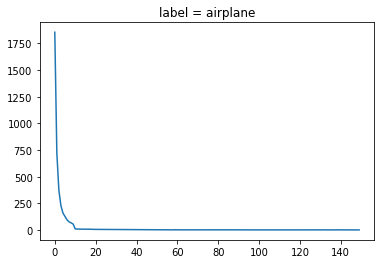

auc =  0.5935175555555555


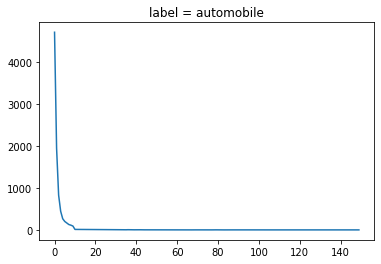

auc =  0.6275768888888887


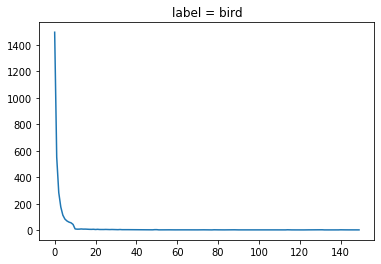

auc =  0.47063599999999994


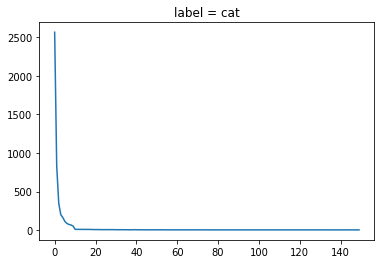

auc =  0.6101826666666667


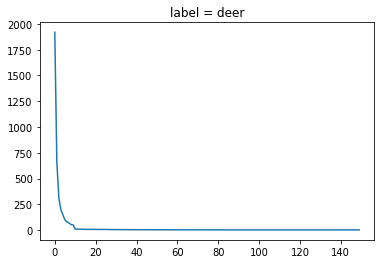

auc =  0.5227634999999999


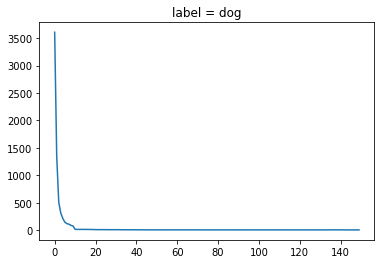

auc =  0.6447898888888889


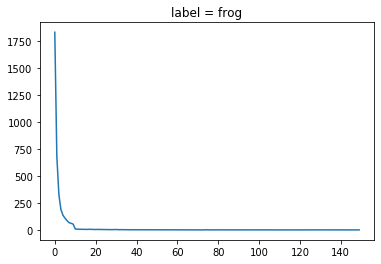

auc =  0.6663095555555556


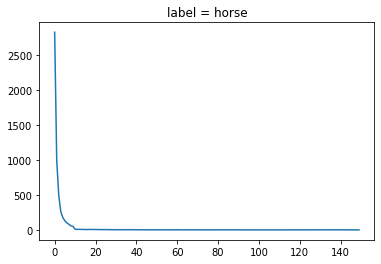

auc =  0.6527662777777778


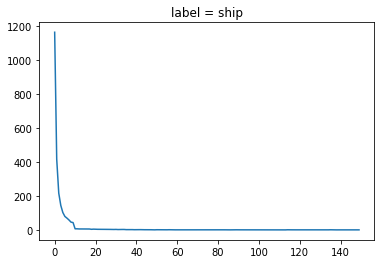

auc =  0.7711713888888889


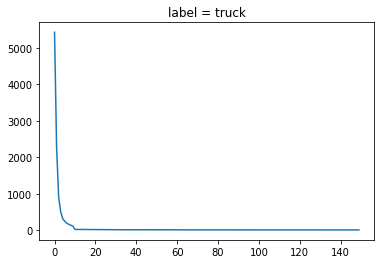

auc =  0.6995227222222222


In [16]:
objective = 'soft-boundary'
i = 0
nu = 0.1
outlier_nu = 0
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []

for label_num in np.arange(10):
    ## 資料設定
    train_dataset, x_train, x_test, y_train, y_test = load_data(label_num, batch_size = 200,
                                                                outlier_nu = outlier_nu)
    ## 訓練 autoencoder
    pre_time = time.time()
    ae = Autoencoder(label_num)
    ae.train_ae(350, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(train_dataset = train_dataset, label_num = label_num , objective = objective, encoder = encoder)
    SVDD.train(x_train, n_epochs = 150)
    radius_end =SVDD.train_result(x_train, y_train)
    test_auc, confusionmatrix  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)
    i += 1

In [17]:
for i in range(len(names)):
    print('label = ', names[i])
    print('auc = ', auc_list[i])
    print('time = ', time_list[i])
    print(confusionmatrix_list[i])

label =  airplane
auc =  0.5935175555555555
time =  246.15763521194458
[[1487 7513]
 [ 118  882]]
label =  automobile
auc =  0.6275768888888887
time =  248.14074611663818
[[2788 6212]
 [ 155  845]]
label =  bird
auc =  0.47063599999999994
time =  246.39579486846924
[[ 832 8168]
 [ 109  891]]
label =  cat
auc =  0.6101826666666667
time =  244.83347082138062
[[2161 6839]
 [ 121  879]]
label =  deer
auc =  0.5227634999999999
time =  244.29768633842468
[[1755 7245]
 [ 154  846]]
label =  dog
auc =  0.6447898888888889
time =  249.2629246711731
[[2972 6028]
 [ 158  842]]
label =  frog
auc =  0.6663095555555556
time =  247.43330478668213
[[2678 6322]
 [  92  908]]
label =  horse
auc =  0.6527662777777778
time =  248.0103781223297
[[2937 6063]
 [ 120  880]]
label =  ship
auc =  0.7711713888888889
time =  246.05769515037537
[[3187 5813]
 [  89  911]]
label =  truck
auc =  0.6995227222222222
time =  247.93882060050964
[[3980 5020]
 [ 196  804]]


In [18]:
objective = 'soft-boundary'
i = 0
nu = 0.1
outlier_nu = 0


for label_num in np.arange(10):
    ## 資料設定
    train_dataset, x_train, x_test, y_train, y_test = load_data(label_num, batch_size = 200,
                                                                outlier_nu = outlier_nu)
    ## 訓練 autoencoder
    pre_time = time.time()
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(train_dataset = train_dataset, label_num = label_num , objective = objective, encoder = encoder)
    radius_end =SVDD.train_result(x_train, y_train)
    test_auc, confusionmatrix  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    i += 1

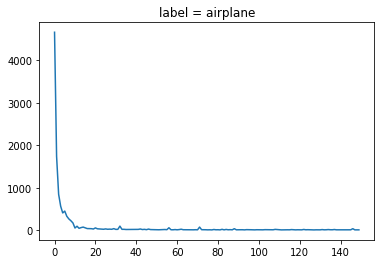

auc =  0.5889552222222222


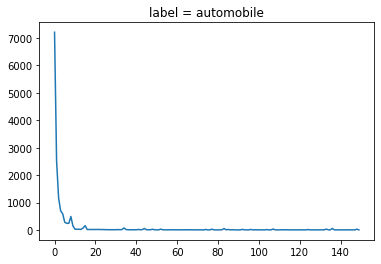

auc =  0.6041779444444445


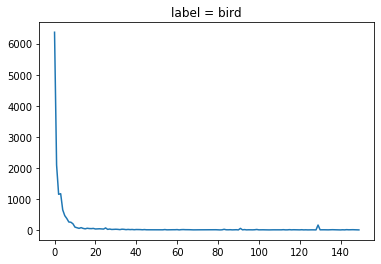

auc =  0.4839379999999999


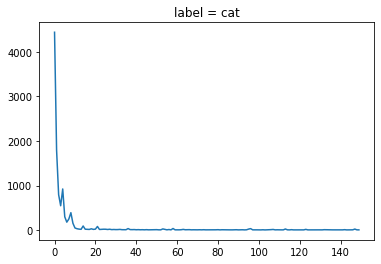

auc =  0.5217078333333334


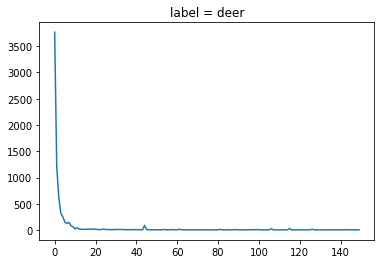

auc =  0.5485768333333334


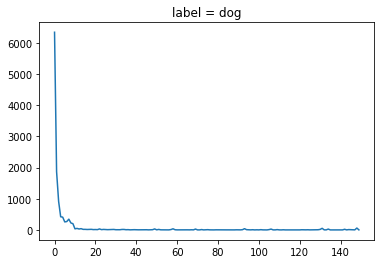

auc =  0.5697901666666666


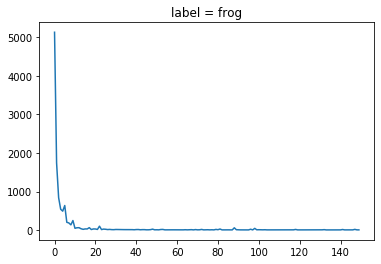

auc =  0.5914675555555555


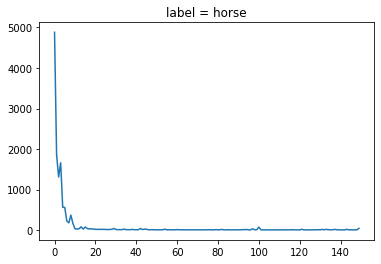

auc =  0.5826312222222222


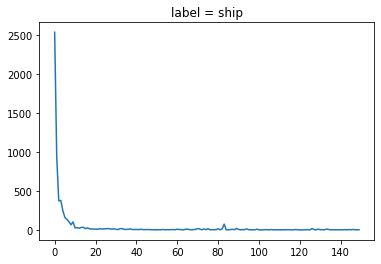

auc =  0.7246950000000001


In [ ]:
objective = 'soft-boundary'
i = 0
nu = 0.1
outlier_nu = 0.1
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []

for label_num in np.arange(10):
    ## 資料設定
    train_dataset, x_train, x_test, y_train, y_test = load_data(label_num, batch_size = 200,
                                                                outlier_nu = outlier_nu)
    ## 訓練 autoencoder
    pre_time = time.time()
    ae = Autoencoder(label_num)
    ae.train_ae(350, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(train_dataset = train_dataset, label_num = label_num , objective = objective, encoder = encoder)
    SVDD.train(x_train, n_epochs = 150)
    radius_end =SVDD.train_result(x_train, y_train)
    test_auc, confusionmatrix  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)
    i += 1

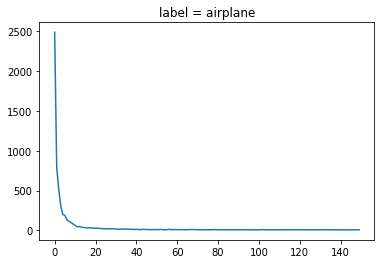

auc =  0.6174309444444445


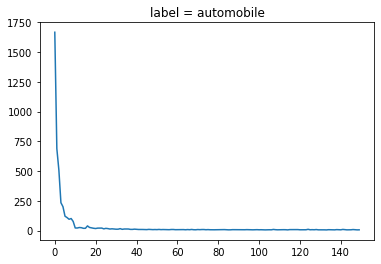

auc =  0.5945320000000001


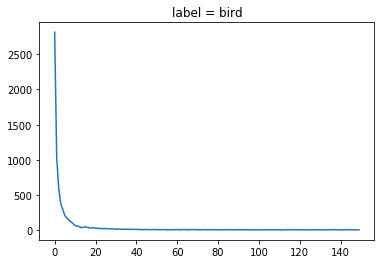

auc =  0.4962631111111111


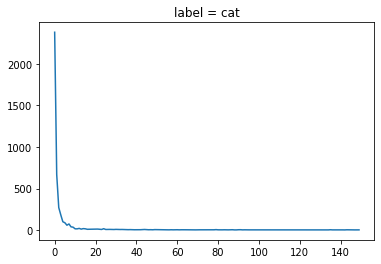

auc =  0.510377388888889


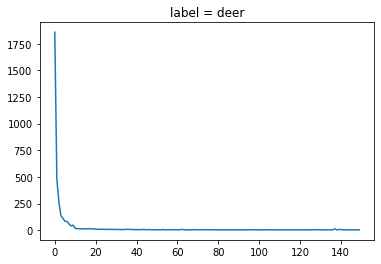

auc =  0.5506297777777778


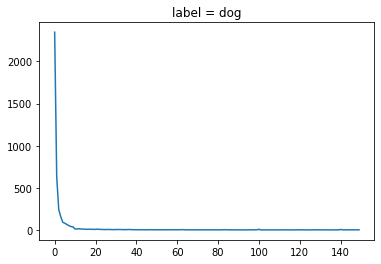

auc =  0.5767747222222223


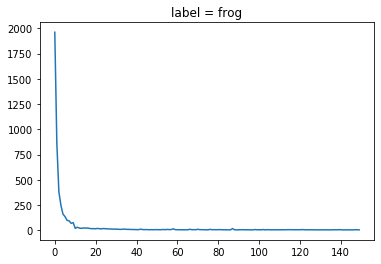

auc =  0.5714633888888889


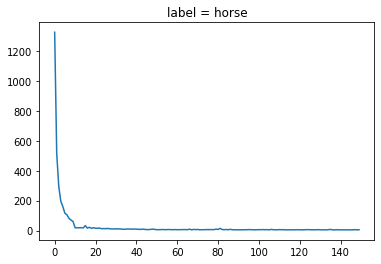

auc =  0.5839056666666667


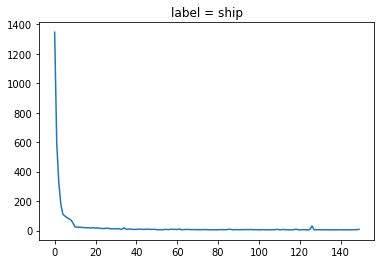

auc =  0.6780762222222223


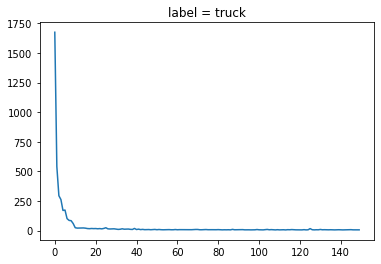

auc =  0.6674378333333334


In [17]:
objective = 'soft-boundary'
i = 0
nu = 0.2
outlier_nu = 0.2
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []

for label_num in np.arange(10):
    ## 資料設定
    train_dataset, x_train, x_test, y_train, y_test = load_data(label_num, batch_size = 200,
                                                                outlier_nu = outlier_nu)
    ## 訓練 autoencoder
    pre_time = time.time()
    ae = Autoencoder(label_num)
    ae.train_ae(350, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(train_dataset = train_dataset, label_num = label_num , objective = objective, encoder = encoder)
    SVDD.train(x_train, n_epochs = 150)
    radius_end =SVDD.train_result(x_train, y_train)
    test_auc, confusionmatrix  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)
    i += 1

In [18]:
for i in range(len(names)):
    print('label = ', names[i])
    print('auc = ', auc_list[i])
    print('time = ', time_list[i])
    print(confusionmatrix_list[i])

label =  airplane
auc =  0.6174309444444445
time =  288.3424835205078
[[ 190 8810]
 [  35  965]]
label =  automobile
auc =  0.5945320000000001
time =  285.9426381587982
[[2379 6621]
 [ 142  858]]
label =  bird
auc =  0.4962631111111111
time =  286.2885935306549
[[ 183 8817]
 [  36  964]]
label =  cat
auc =  0.510377388888889
time =  288.0035471916199
[[ 757 8243]
 [  64  936]]
label =  deer
auc =  0.5506297777777778
time =  289.2272641658783
[[ 714 8286]
 [  65  935]]
label =  dog
auc =  0.5767747222222223
time =  280.7212426662445
[[ 374 8626]
 [  21  979]]
label =  frog
auc =  0.5714633888888889
time =  289.76577615737915
[[1160 7840]
 [  61  939]]
label =  horse
auc =  0.5839056666666667
time =  289.4905722141266
[[2169 6831]
 [ 144  856]]
label =  ship
auc =  0.6780762222222223
time =  282.35827827453613
[[  25 8975]
 [   0 1000]]
label =  truck
auc =  0.6674378333333334
time =  278.9040505886078
[[3013 5987]
 [ 145  855]]


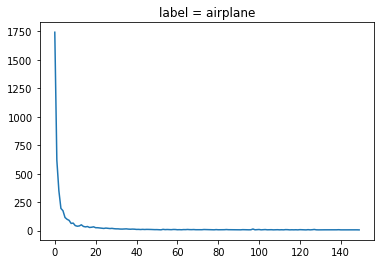

auc =  0.6069626666666667


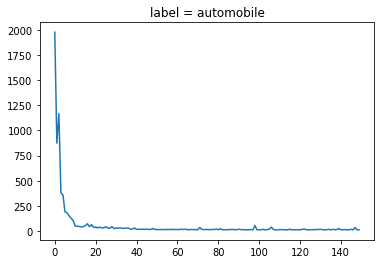

auc =  0.5580329444444445


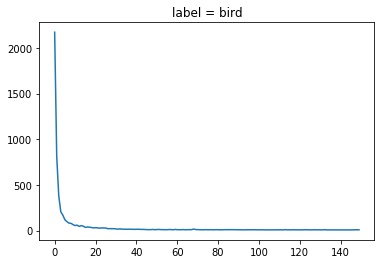

auc =  0.47320249999999997


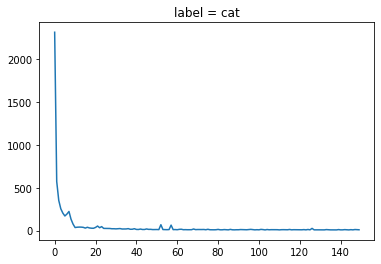

auc =  0.5252887222222222


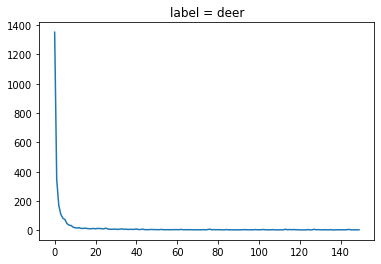

auc =  0.5492582777777778


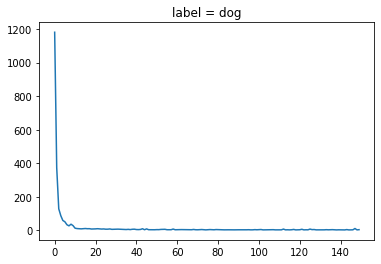

auc =  0.5599119444444445


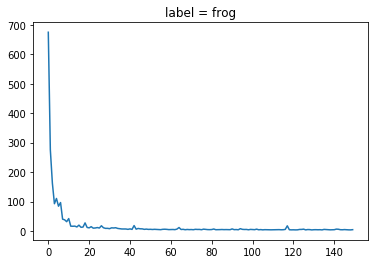

auc =  0.5463498888888889


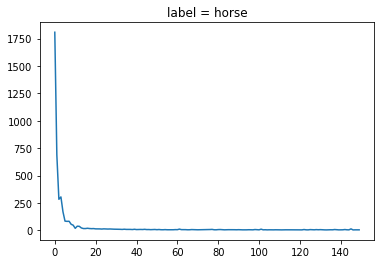

auc =  0.6176732222222223


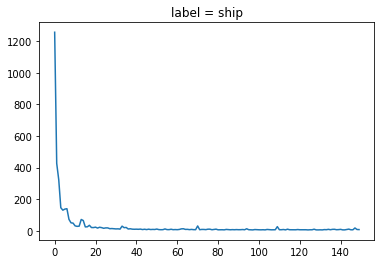

auc =  0.6470263333333333


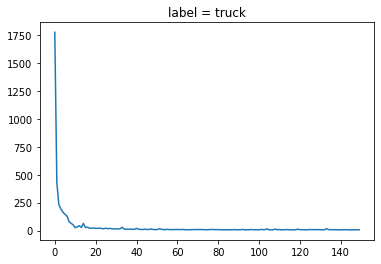

auc =  0.6511520000000001


In [16]:
objective = 'soft-boundary'
i = 0
nu = 0.3
outlier_nu = 0.3
label_list = []
auc_list = []
time_list = []
confusionmatrix_list = []

for label_num in np.arange(10):
    ## 資料設定
    train_dataset, x_train, x_test, y_train, y_test = load_data(label_num, batch_size = 200,
                                                                outlier_nu = outlier_nu)
    ## 訓練 autoencoder
    pre_time = time.time()
    ae = Autoencoder(label_num)
    ae.train_ae(350, train_dataset)
    encoder = ae.encoder
    ## 訓練 SVDD
    SVDD = train_SVDD(train_dataset = train_dataset, label_num = label_num , objective = objective, encoder = encoder)
    SVDD.train(x_train, n_epochs = 150)
    radius_end =SVDD.train_result(x_train, y_train)
    test_auc, confusionmatrix  = SVDD.test(x_test, y_test, radius_end)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    label_list.append(label_num)
    auc_list.append(test_auc)
    time_list.append(train_time)
    confusionmatrix_list.append(confusionmatrix)
    i += 1